## Karger Algorithm for weighted graph

Pipeline:
1. converting interval of time
2. filtering dictionary using interval of time
3. KARGER ALGORITHM 
4. Visualization

### importing the data

In [1]:
import pickle

with open('../data/interactions.pickle', 'rb') as handle:
    my_dict = pickle.load(handle)

#(user2,time_stamp,score_associated_to_interaction)

### Part 1: converting time interval

In [2]:
def from_date_to_int(date):
    '''
    INPUT: (day,month,year)
    OUTPUT: correspondent integer
    '''
    if date[1]==2:
        integer=date[0]+date[1]*28+(date[2]-1970)*365
    if date[1] in [4,6,9,11]:
        integer=date[0]+date[1]*30+(date[2]-1970)*365
    else:
        integer=date[0]+date[1]*31+(date[2]-1970)*365
    return(integer)

In [3]:
def convert_interval(interval):
    '''
    INPUT= interval of time in format [(dd,mm,yyyy),(dd,mm,yyyy)] --> [start,end]
    OUTPUT: interval of time in format [encoded_start,encoded_end] where encoded are integers values
    '''
    new_int=[]
    for date in interval:
        new_int.append(from_date_to_int(date))
    
    return( new_int)

In [4]:
#imagine to take in input date in format [(dd,mm,yyyy),(dd,mm,yyyy)]

#first day included, second day escluded
interval=[(29,7,2008),(30,7,2008)] 

converted_interval=convert_interval(interval)
converted_interval

[14116, 14117]

### Part 2: filtering dictionary using the interval

In [5]:
def filter_dictionary(dictionary,converted_interval): 
    '''
    INPUT: dictionary 
           interval of time encoded 
    OUTPUT: dictionary filtered that has just the interactions in that time interval
    '''
    filtered_dictionary={}
    for key,value in dictionary.items():
        for elem in value:
            if ( (elem[1]>=converted_interval[0] and elem[1]<converted_interval[1]) ): # or (elem[1]>converted_interval[2] and elem[1]<converted_interval[3]) ):
                try:
                    filtered_dictionary[key].append(elem)
                except:
                    filtered_dictionary[key]=[elem]
    return(filtered_dictionary)  

In [6]:
filtered_dictionary=filter_dictionary(my_dict,converted_interval)


In [7]:
len(filtered_dictionary)

232

Create the final dictionary eliminating the edges that start from a node a go to the same node and take the sum if there are two edges that start from the same node and point the same node.
This dictionary does not have timestamp anymore since we do not require it anymore

**Example** : 
* if i have {1:[(1,10)]} I drop this element since user1 gives an answer to himself
* if i have {1:[(2,10),(2,5)]} i take {'1,2':sum(10+5)}

In [8]:

G={}
# go through the dictionary
for k,v in  filtered_dictionary.items():
    # slice the list attached to every element
    for value in v:
        # remove people that speaks with themselves
        if k!=value[0]:
            try:
                #sum weight between the same nodes
                previous= G[str(k)+','+str(value[0])]
                G[str(k)+','+str(value[0])].append(previous+value[2])
            except:
                G[str(k)+','+str(value[0])]=[value[2]]
   

In [9]:
if(len(G))==0:
    print('in this interval we do not have users')

The dictionary has the format  {'user1,user2':[score_of_interactions]}: you can uncomment to see if you are curious 

In [10]:
#G

# Part 3: Karger Algorithm

 For the supernode I will use the format 'nodex|nodey|nodez' 


Contraction function: select a random node from a graph, take another node connected to the first one randon and merged them together creating a supernode

In [11]:
import random
def contraction (G):
    '''
    INPUT: a graph 
    during every itertion also len(G) became len(G)-1
    OUTPUT: the graph in which I have contracted to random nodes 
    '''
    
    edge_between=random.choice(list(G))
    node1_to_merge=edge_between.split(',')[0]
    node2_to_merge=edge_between.split(',')[1]

    #delete edge between the two  nodes
    del G[edge_between]
    t=node1_to_merge+'|'+node2_to_merge
    

    G_new=G.copy()

    for k,v in G.items():
        
        #edges from node1_to_merge
        if k.split(',')[0]==node1_to_merge:
            if k in G_new:
                del G_new[k]
            try:
                previous=G_new[t+','+k.split(',')[1]]
                G_new[t+','+k.split(',')[1]]=v+previous
            except:
                G_new[t+','+k.split(',')[1]]=v

        #edges from node2_to_merge
        if k.split(',')[0]==node2_to_merge:
            if k in G_new:
                del G_new[k]
            try:
                previous=G_new[t+','+k.split(',')[1]]
                G_new[t+','+k.split(',')[1]]=v+previous
            except:
                G_new[t+','+k.split(',')[1]]=v

        #edges directed to node1_to_merge
        if k.split(',')[1]==node1_to_merge:
            if k in G_new:
                del G_new[k]
            try:
                previous=G_new[k.split(',')[0]+','+t]
                G_new[k.split(',')[0]+','+t]=v+previous
            except:
                G_new[k.split(',')[0]+','+t]=v

        #edges directet to node2_to_merge except the one that cinnect node1_to_merge and node2_to_merge
        if k.split(',')[1]==node2_to_merge:
            if k in G_new:
                del G_new[k]
            try:
                previous=G_new[k.split(',')[0]+','+t]
                G_new[k.split(',')[0]+','+t]=v+previous
            except:
                G_new[k.split(',')[0]+','+t]=v

    return G_new
        





The following function computer a single iteration of Karger Algorithm but we are not sure that this will produce a correct an admissible result: we will need to run more times

In [12]:
import math
def iteration(G,s,t):
    '''
    INPUT= G
    OUTPUT= cut of G if it is ammisible, inf otherwise
    '''
    G_new=G.copy()
    while len(G_new)>1:
        G_new=contraction(G_new)


    ###check if it  is a valid cut: s and t need to be in two different partition. I store the partitions because they are necessary for the visualization
    for k,v in G_new.items():
        partition1=k.split(',')[0]
        partition2=k.split(',')[1]

    elements=[x for x in partition1.split('|')]
    cont=0
    for elem in elements:
        if (elem==s or elem==t):
            cont+=1

    if cont==1:
        cut=sum(list(G_new.values())[0]) 
    else:
        cut=math.inf
    
    return cut,partition1,partition2

In [13]:
def Karger(G,s,t):

    # check if s and t are in the graph otherwise we can not compute the algorithm
    conts=0
    contt=0
    for k,v in G.items():
        if (k.split(',')[0]==s or k.split(',')[1]==s):
            conts+=1
        if (k.split(',')[0]==t or k.split(',')[1]==t):
            contt+=1
    if (conts<1 or contt<1):
        return(' users not in the graph')

    #### If we can efctively run the algorithm###   
    min_cut=math.inf
    partitionA={}
    partitionB={}
    # I ran len G times even if it is not correct just for time reason but we can change this parameter
    for i in range(len(G)):
        cut,partition1,partition2=iteration(G,s,t)
        if cut<min_cut:
            min_cut=cut
            partitionA=partition1
            partitionB=partition2
            
    return(min_cut,partitionA,partitionB)

### We can execute the algorith in a real situation: every check was positive so i expect a result, at least a non admissible one

In [14]:
min_cut,partitionA,partitionB=Karger(G,'17','51')

In [15]:
min_cut

10

# Visualization4 

We can decide between many different visualization but I think the most rappresentative one is the last cut between the two partitions of the graph.
In addition, is very difficult to represent a large number of links in a single image and this goes in opposite direction with respect to the idea of helping understand the process with an image.

In [16]:
import networkx as nx
G=nx.Graph()

In [17]:

G.add_edge('partitionA','partitionB',weight=min_cut)

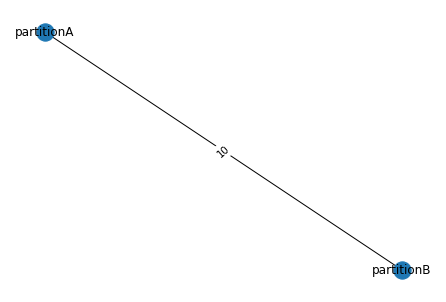

In [18]:
import matplotlib.pyplot as plt
nx.draw(G, with_labels=True)
pos=nx.spring_layout(G)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);